<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/fonttools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loads TrueType fonts using https://pypi.org/project/TTFQuery/ (Py3 version from https://github.com/mindw/ttfquery), and triangulates them using https://rufat.be/triangle/ library, and Shapely https://shapely.readthedocs.io/en/stable/manual.html for geometry.
Builds a Triangle Stack, a list of points with implicit rules for building a triangled font glyph (character) from the points as follows:

1. Each element consists of an optional point and an optional triangle (represented by 2 bools).
2. If present the point (x, y floats) is added to a stack.
3. If present the triangle is represented by the latest point and two relative offsets in the stack (2 ints)

*TODO*
Import from Google Fonts https://developers.google.com/fonts/docs/developer_api or https://github.com/google/fonts/archive/master.zip


# Imports

In [2]:
#@title Imports
#jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888
#from enum import Enum, IntEnum
from copy import copy
import math
import os
import collections
import glob 
import copy
#import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf
print("np", np.__version__)
print("tf", tf.__version__)
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageChops
from IPython.display import display

#!pip install triangle
import triangle as tr
print("tr", tr.__version__)

#!pip install fonttools
#from fontTools.ttLib import TTFont

# should be:
#!pip install ttfquery
# or 
#!conda install -c mwcraig ttfquery
# but actually had to:
#git clone git@github.com:mindw/ttfquery.git
#cd ttfquery
#python setup.py install

import ttfquery.describe
import ttfquery.glyph
import ttfquery.findsystem
print("ttfquery", ttfquery.__version__)

#!pip install shapely
# or on windows:
#!conda config --add channels conda-forge
#!conda install shapely
import shapely.ops
import shapely.geometry
import shapely.affinity
print("shapely", shapely.__version__)

#!pip install descartes
import descartes


#Mar2019:
# np 1.14.2
# tf 1.10.0
# tr 20190115.1
# ttfquery 1.0.5
# shapely 1.6.4.post2

np 1.16.2
tf 1.13.1
tr 20190115.1
ttfquery 1.0.5
shapely 1.6.4.post2


# Setup

In [0]:
def readFonts(files: [str], glyphs: str): # type: List(List[MultiPolygon))
  print('loading {} files'.format(len(files)))
  tolerance = 0.001
  fonts = []
  for fontfile in files:
    try:
      print(fontfile)
      font = ttfquery.describe.openFont(fontfile)
      multipolys = []
      for glyph in glyphs:
        g = ttfquery.glyph.Glyph(glyph)
        g.compile(font, steps=2)
        contours = [shapely.geometry.LinearRing(contour) for contour in g.outlines]
        #contours = [shapely.geometry.LinearRing(contour) for contourflags in g.calculateContours(font) for contour, flag in contourflags]
        size = 1.0
        contours = [shapely.affinity.scale(contour, size/g.height, size/g.height, origin=(0,0.1))
                    for contour in contours]
        polys = []
        holes = []
        # Find contours inside other contours and make them holes
        for contour in contours:
          for i, poly in enumerate(polys):
            if shapely.geometry.Polygon(contour).contains(shapely.geometry.Polygon(poly)):
              #replace
              polys[i] = contour
              holes[i].append(poly)
              break
            elif shapely.geometry.Polygon(poly).contains(shapely.geometry.Polygon(contour)):
              holes[i].append(contour)
              break
          else:
            polys.append(contour)
            holes.append([])
        multipolys.append(shapely.geometry.MultiPolygon(
            [shapely.geometry.Polygon(poly, hole).simplify(tolerance) for poly, hole in zip(polys, holes)]))
      fonts.append(multipolys)
    except Exception as e:
      print(e)
  print('loaded {} files'.format(len(fonts)))
  return fonts

In [72]:
print('setup...')
glyphs = [chr(i) for i in range(ord('A'), ord('Z')+1)]
glyphs += [chr(i) for i in range(ord('a'), ord('z')+1)]
glyphs += ['zero','one','two','three','four','five','six','seven','eight','nine']
max_outline_points = 200
#files = glob.glob('deeper/fonts/*.ttf')
#files = list(ttfquery.findsystem.findFonts())
google_font_dir = r'C:\Users\terry\Downloads\fonts-master\apache'
#google_font_dir = r'C:\Users\terry\Downloads\fonts-master\ofl'
dirs = [os.path.join(google_font_dir, dir) for dir in os.listdir(google_font_dir)]
files = []
for dir in dirs:
  if 'sans' in open(os.path.join(dir, 'DESCRIPTION.en_us.html')).read():
    files += [os.path.join(dir, f) for f in os.listdir(dir) if 'ttf' in f] 
np.random.seed(2)
#np.random.shuffle(files)
#files = files[0:5]
print(files)
fonts = readFonts(files, glyphs)
#print(fonts[0][0])


setup...
['C:\\Users\\terry\\Downloads\\fonts-master\\apache\\aclonica\\Aclonica-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-Bold.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-BoldItalic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-Italic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\arimo\\Arimo-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cherrycreamsoda\\CherryCreamSoda-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-Bold.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-BoldItalic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-Italic.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\cousine\\Cousine-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\luckiestguy\\LuckiestGuy-Regular.ttf', 'C:\\Users\\terry\\Downloads\\fonts-master\\apache\\opensans\\OpenSan

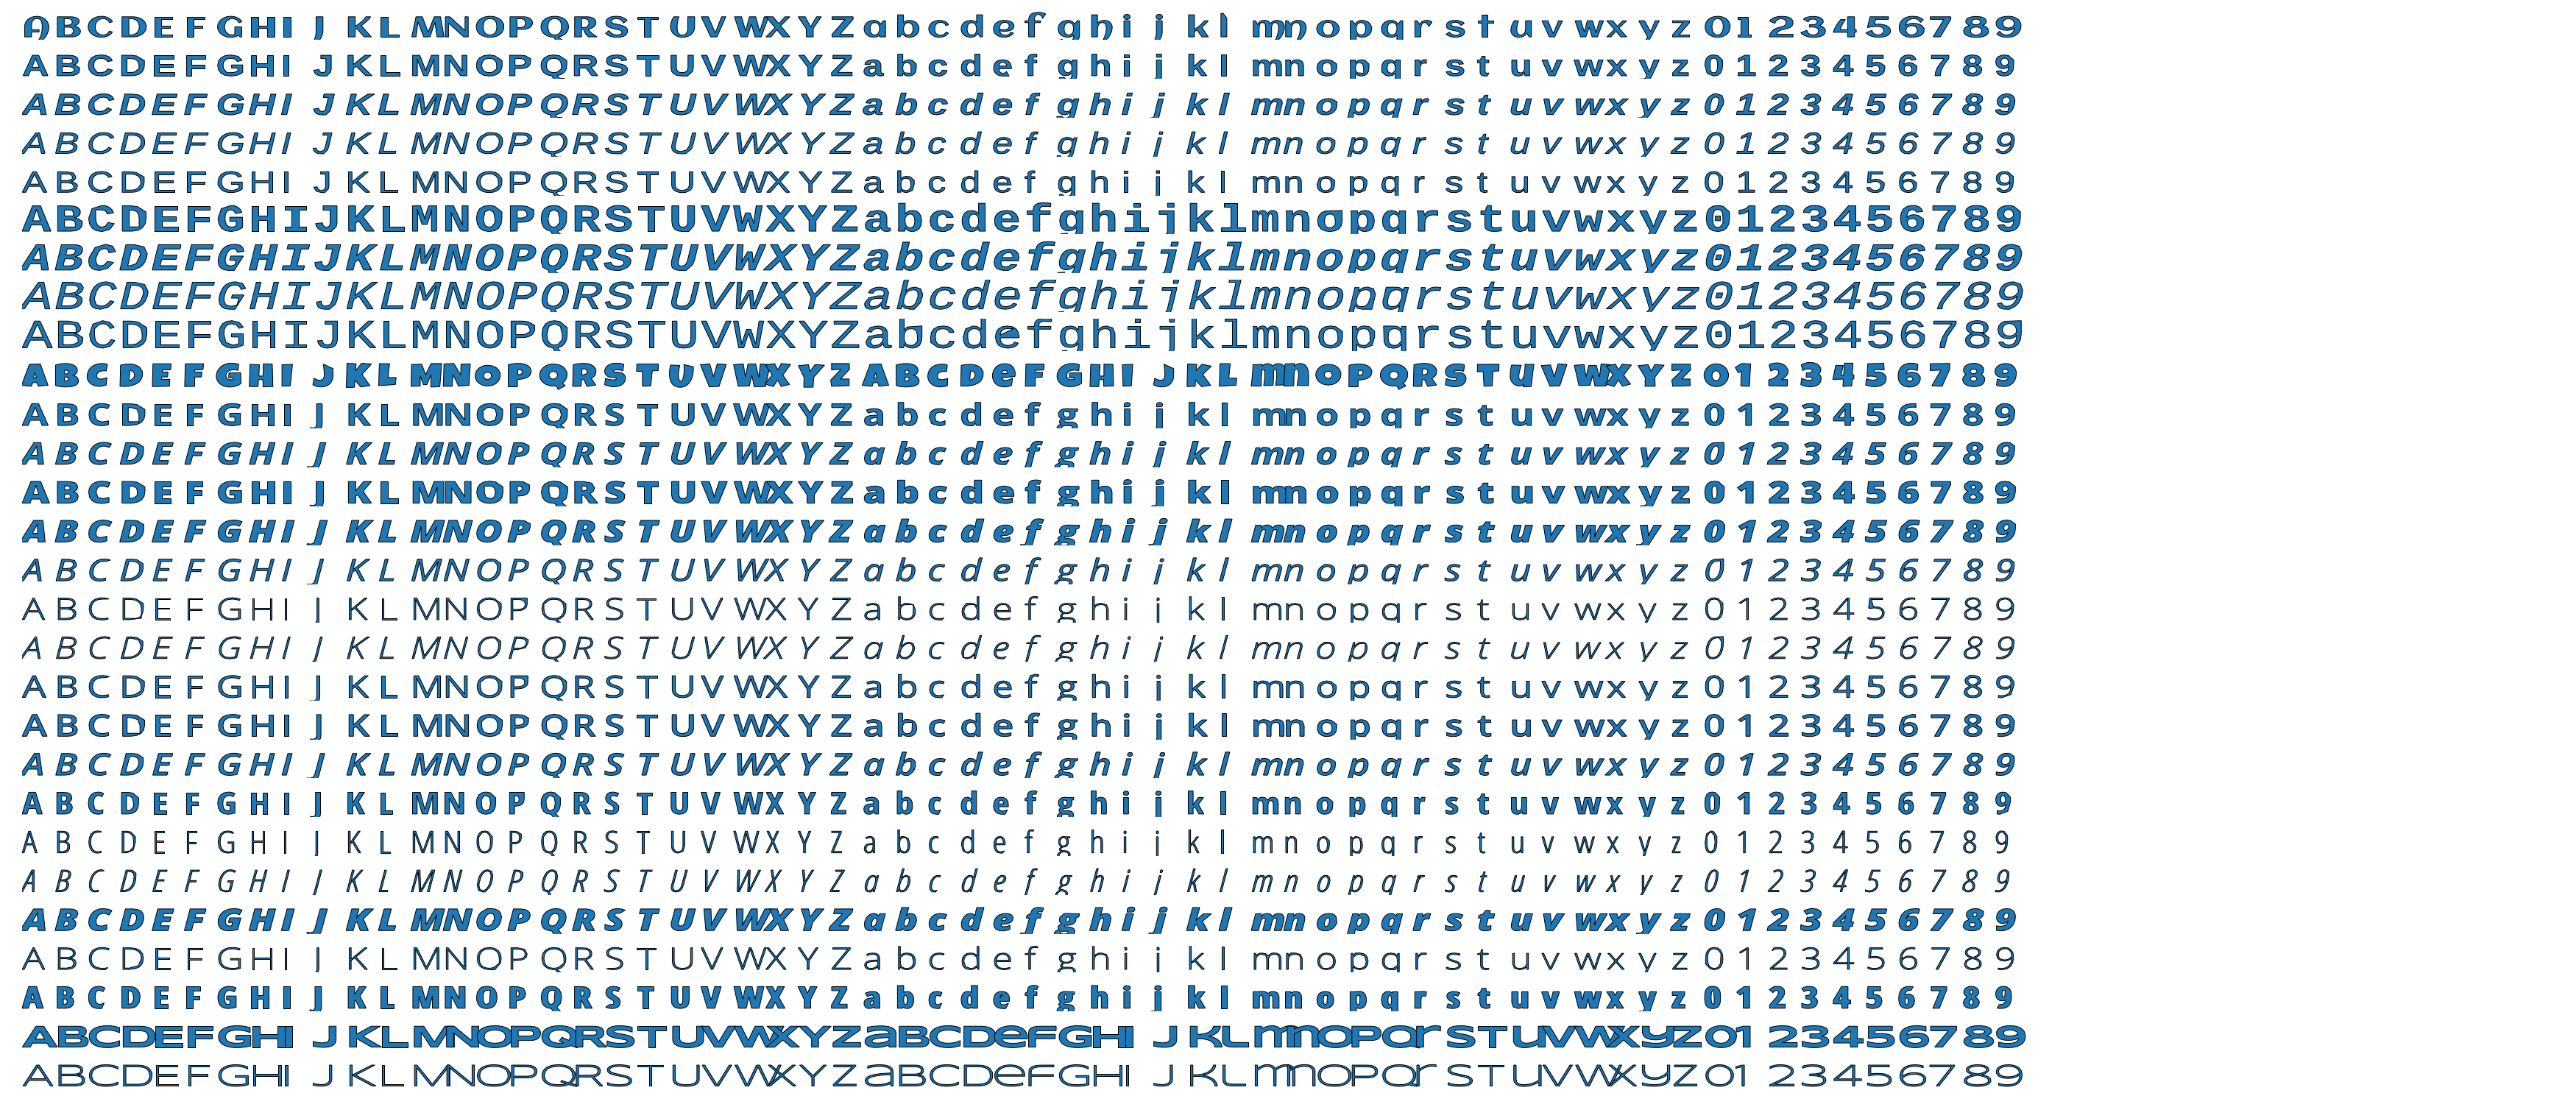

In [73]:
def drawMultiPolygons(polygons):
  fonts = len(polygons)
  glyphs = max([len(polygon) for polygon in polygons])
  plt.figure(figsize=(glyphs,fonts))
  for f in range(fonts):
    ax = plt.subplot(fonts+1, 1, 1+f)
    ax.set_xlim(0, glyphs+1)
    ax.set_axis_off()
    for glyph in range(glyphs):
      ax.add_patch(descartes.PolygonPatch(
          shapely.affinity.translate(polygons[f][glyph], glyph*0.8)
      ))
  plt.show()

drawMultiPolygons(fonts)


In [0]:
# Shapely triangulation doesn't handle holes, so use tr module instead
#triangles = shapely.ops.triangulate(fonts[0][0])

def add_poly(coords, vertices, segments):
  start = len(vertices)
  vertices += coords[:-1]
  segments += [(i, i+1) for i in range(start, start+len(coords)-2)]
  segments.append((start+len(coords)-2, start))

def get_T(glyph):
  vertices = []
  segments = []
  holes = []
  for poly in glyph:
    add_poly(poly.exterior.coords, vertices, segments)
    for interior in poly.interiors:
      add_poly(interior.coords, vertices, segments)
      holes.append(shapely.geometry.Polygon(interior).representative_point().coords[:])
  T = {
    'vertices': np.array(vertices),
    'segments': np.array(segments),
  }
  if holes:
    T['holes'] = np.array(holes).reshape((-1,2))
  return T


In [74]:
#@ Populate nptris
nptris = np.empty((len(fonts), len(glyphs)), dtype=dict)
for f in range(len(fonts)):
  for g in range(len(glyphs)):
    T = get_T(fonts[f][g])
    opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
    #opts += 'q20' # conforming constrained Delaunay triangulation of a PSLG 
    #opts += 'D' # conforming Delaunay triangulation 
    nptris[f,g] = tr.triangulate(T, opts)
    #print(f, g, len(vertices), nptris[f,g]['triangles'].shape)

counts = [(glyphs[g],
           nptris[f,g]['vertices'].size,
           nptris[f,g]['triangles'].size,
           np.bincount(nptris[f,g]['triangles'].flatten()).max(), # vertex used by max number of triangles
           (np.bincount(nptris[f,g]['triangles'].flatten())==np.bincount(nptris[f,g]['triangles'].flatten()).max()).sum(), # vertices sharing max triangles
          )
          for f in range(len(fonts)) for g in range(len(glyphs))]
print(counts)
print("max values: ", [max(v[i] for v in counts) for i in range(len(counts[0]))])
print("max tris: ", counts[max((c[2],i) for i, c in enumerate(counts))[1]])
#print([c for c in counts if c[3]>6])
#print([c for c in counts if c[4]>8])
#plt.figure(figsize=(50,2))
# tr.plot(ax,
#         vertices=[p for poly in triangles for p in poly.exterior.coords],
#         triangles=[(i, i+1, i+2) for i in range(len(triangles))]
#        )
# for i,poly in enumerate(triangles):
#   ax = plt.subplot(1, len(triangles), 1+i)
#   ax.add_patch(descartes.PolygonPatch(poly))
#plt.show()

[('A', 132, 192, 4, 11), ('B', 142, 219, 9, 1), ('C', 154, 225, 4, 10), ('D', 88, 132, 5, 2), ('E', 24, 30, 5, 1), ('F', 20, 24, 5, 1), ('G', 146, 213, 5, 1), ('H', 24, 30, 5, 1), ('I', 8, 6, 2, 2), ('J', 40, 54, 3, 16), ('K', 36, 48, 5, 2), ('L', 12, 12, 4, 1), ('M', 26, 33, 5, 3), ('N', 20, 24, 5, 2), ('O', 150, 225, 4, 13), ('P', 78, 117, 6, 1), ('Q', 182, 273, 7, 1), ('R', 96, 144, 6, 1), ('S', 212, 312, 5, 1), ('T', 16, 18, 4, 2), ('U', 114, 165, 4, 9), ('V', 14, 15, 5, 1), ('W', 26, 33, 5, 3), ('X', 24, 30, 6, 2), ('Y', 18, 21, 5, 1), ('Z', 20, 24, 5, 2), ('a', 144, 216, 7, 2), ('b', 144, 216, 8, 1), ('c', 132, 192, 4, 8), ('d', 142, 213, 9, 1), ('e', 192, 288, 5, 2), ('f', 78, 111, 5, 2), ('g', 206, 309, 8, 1), ('h', 100, 144, 8, 1), ('i', 70, 93, 7, 2), ('j', 102, 141, 7, 2), ('k', 44, 60, 6, 1), ('l', 10, 9, 3, 1), ('m', 160, 234, 8, 1), ('n', 108, 156, 7, 1), ('o', 172, 258, 4, 12), ('p', 146, 219, 9, 1), ('q', 144, 216, 10, 1), ('r', 72, 102, 6, 1), ('s', 192, 282, 5, 3), ('

In [20]:
def drawTris(nptris):
  shape = nptris.shape
  plt.figure(figsize=(shape[1]*2,shape[0]*2))
  for f in range(shape[0]):
    for g in range(shape[1]):
      if nptris[f,g]:
        ax = plt.subplot(shape[0], shape[1], f*shape[1]+g+1)
        #ax.set_xlim(0, shape[1]+1)
        ax.set_axis_off()
        tr.plot(ax, **nptris[f,g])
        #tr.plot(ax, vertices=nptris[f,g]['vertices'])
        #ax.add_patch(descartes.PolygonPatch(
        #  shapely.affinity.translate(polygons[font][glyph], glyph*0.8)
        #))
  #plt.tight_layout()
  plt.show()

drawTris(nptris)


# Build and test TriangleStack

('eight', 122, 189, 5, 5)
189


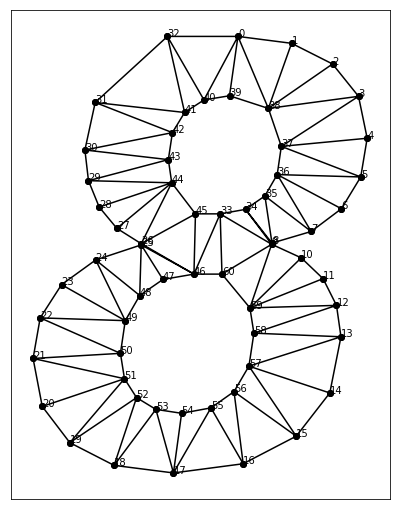

In [75]:
font,glyph_num=2,glyphs.index('eight')
glyph = nptris[font,glyph_num]
#print(nptris[f,g]['triangles'][0:10])
print(counts[font*len(glyphs)+glyph_num])
print(np.bincount(glyph['triangles'].flatten()).sum())
plt.figure(figsize=(7,9))
ax = plt.subplot(111)
tr.plot(ax, vertices=glyph['vertices'], triangles=glyph['triangles'], labels=1)
plt.show()

In [76]:
class TriangleStack(object):
  Element = collections.namedtuple("Element", ["vertex", "triangle_offsets"])
  # vertex: Optional(List[float, 2])
  # triangle_offsets: Optional(List(int, 2))
  
  def __init__(self, elements):
    self._elements = elements
    
  @property
  def elements(self):
    return self._elements
  
  def get_triangles(self, debug=False):
    if debug:
      print("\nget_triangles")
    vertices = []
    triangles = []
    for vertex, triangle in self._elements:
      if vertex is not None:
        vertices.append(vertex)
      if triangle is not None:
        last_vertex = len(vertices)-1
        triangles.append([last_vertex, last_vertex-1-triangle[0], last_vertex-2-triangle[1]])
    if debug:
      print(vertices, triangles)
      
    return {'vertices': vertices, 'triangles': triangles}

  @classmethod    
  def build_stack(cls, nptri, debug=False):
    elements = []
    vertex_index_to_old_index = []
    vertices = nptri['vertices']
    triangles = copy.copy(nptri['triangles'])
    if debug:
      print("\nbuild_stack")
      #print(vertices)
      #print(triangles)
    def add_vertex(index):
      if debug:
        print("add_vertex: ", index)
      elements.append(TriangleStack.Element(vertices[index], None))
      vertex_index_to_old_index.append(index)
    def add_triangle(j, k):
      i = len(vertex_index_to_old_index)-1
      triangle_offsets = [i-j-1, i-k-2]
      if debug:
        print("add_triangle: ", (i, j, k), "->", triangle_offsets)
      if not elements[-1].triangle_offsets:
        elements[-1] = TriangleStack.Element(elements[-1].vertex, triangle_offsets)
      else:
        elements.append(TriangleStack.Element(None, triangle_offsets))
    index = -1
    while triangles.max()>-1:
      if debug:
        print("index: %d, last element: %s, vertices: %s" %(index, elements[-1] if elements else "", vertex_index_to_old_index))
      if debug:
        print("Add next vertex")
      for i in range(len(vertex_index_to_old_index)-1, -1, -1):
        matches = ((triangles==index) + (triangles==vertex_index_to_old_index[i])).sum(axis=1)
        assert 0 <= matches.max() <= 2
        matching_tris = (matches==2).nonzero()[0]
        if matching_tris.size:
          # Add index from triangle with 2 other matches
          tri_index = np.random.choice(matching_tris)
          indices = list(triangles[tri_index])
          if debug:
            print("matches2: ", matching_tris, matches, tri_index, indices)
          indices.remove(index)
          indices.remove(vertex_index_to_old_index[i])
          index = indices[0]
          add_vertex(index)
          break
      else:
        matches = (triangles==index).sum(axis=1)
        assert 0 <= matches.max() <= 1
        matching_tris = (matches==1).nonzero()[0]
        if matching_tris.size:
          if debug:
            print("triangle matches 1, pick from: ", matching_tris)
          pick_triangles = triangles[matching_tris]
          pick_triangles[pick_triangles==index] = -1
        else:
          pick_triangles = triangles
        # Add index with min uses overall
        vertex_use_counts = np.bincount(pick_triangles[pick_triangles>=0].flatten())
        vertex_use_counts[vertex_use_counts==0] = 999
        if debug:
          print("vertex_use_counts: ", vertex_use_counts, pick_triangles)
        indices = (vertex_use_counts==vertex_use_counts.min()).nonzero()[0]
        if debug:
          print("min indices: ", indices)
        index = np.random.choice(indices)
        add_vertex(index)        

      # Add any triangles possible, closest matches first
      if debug:
        print("Add any triangles")
      for i in range(len(vertex_index_to_old_index)-2, -1, -1):
        for j in range(i-1, -1, -1):
          matching_tris = ((triangles==index) 
                           + (triangles==vertex_index_to_old_index[i]) 
                           + (triangles==vertex_index_to_old_index[j])).sum(axis=1)
          if matching_tris.max()==3:
            tri = (matching_tris==3).nonzero()[0][0]
            if debug:
              print("tris: ", tri, matching_tris)
            add_triangle(i, j)
            triangles[tri] = -1

    if debug:
      print("Done build_stack")
    return cls(elements)
        
tri_stack = TriangleStack.build_stack(glyph, debug=True)
print("Stack: ", tri_stack._elements)
triangles = tri_stack.get_triangles(debug=True)


build_stack
index: -1, last element: , vertices: []
Add next vertex
vertex_use_counts:  [4 2 2 3 2 3 2 3 3 5 2 2 3 3 2 3 3 4 3 3 2 3 3 2 3 4 4 2 2 3 3 3 3 4 3 3 4
 4 5 2 3 3 3 3 5 3 5 2 3 4 3 4 3 3 2 3 3 4 3 5 3] [[20 51 21]
 [19 51 20]
 [22 21 50]
 [49 22 50]
 [22 49 23]
 [50 21 51]
 [19 18 52]
 [52 18 53]
 [17 54 53]
 [54 17 55]
 [51 19 52]
 [24 49 48]
 [23 49 24]
 [18 17 53]
 [25 48 47]
 [24 48 25]
 [44 28 27]
 [44 29 28]
 [31 30 42]
 [43 30 29]
 [44 43 29]
 [44 26 45]
 [46 45 26]
 [45 46 33]
 [26 25 46]
 [42 41 31]
 [30 43 42]
 [41 32 31]
 [32 41 40]
 [27 26 44]
 [47 46 25]
 [55 16 56]
 [16 55 17]
 [57 56 15]
 [59 58 12]
 [58 57 13]
 [60 59  9]
 [15 56 16]
 [33 46 60]
 [14 13 57]
 [13 12 58]
 [11 59 12]
 [60  9 33]
 [ 9 59 10]
 [11 10 59]
 [14 57 15]
 [34  9  8]
 [33  9 34]
 [36 35  7]
 [ 8 35 34]
 [40 39  0]
 [ 0 38  1]
 [38  0 39]
 [40  0 32]
 [ 6  5 36]
 [ 6 36  7]
 [ 5 37 36]
 [37  5  4]
 [38  2  1]
 [ 2 38  3]
 [ 4  3 37]
 [38 37  3]
 [ 7 35  8]]
min indices:  [ 1  2  4  6 10

In [34]:
glyph['labels']=1
triangles['labels']=1
tr.compare(plt, glyph, triangles, figsize=(20,10))
plt.show()

# Write TFRecord

In [78]:
# Write to collection

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _string_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))
def _float_array_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

#drive.mount('/content/gdrive')
#with open('/content/gdrive/My Drive/fonts8.tfrecords', 'w') as f:
#  f.write('Hello Google Drive!')

MAX_ELEMENTS = 150
filename = r'C:\src\notebooks\deeper\fonts\fonts26sans.tfrecords'
print('Writing', filename)
max_elements = 0
with tf.io.TFRecordWriter(filename) as writer:
  for f in range(len(fonts)):
    print("font: ", f, files[f])
    for g in range(len(glyphs)):
      T = get_T(fonts[f][g])
      opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
      #opts += 'q20' # conforming constrained Delaunay triangulation of a PSLG 
      #opts += 'D' # conforming Delaunay triangulation 
      nptri = tr.triangulate(T, opts)
      tri_stack = TriangleStack.build_stack(nptri)
      print("Stack elements: ", glyphs[g], len(tri_stack.elements))
      max_elements = max(max_elements, len(tri_stack.elements))
      elements = [[1.0 if vertex is not None else 0.0,
                 vertex[0] if vertex is not None else 0.0,
                 vertex[1] if vertex is not None else 0.0,
                 1.0 if offsets is not None else 0.0,
                 float(offsets[0]) if offsets is not None else 0.0,
                 float(offsets[1]) if offsets is not None else 0.0
                ] for vertex, offsets in tri_stack.elements]
      if len(elements)>MAX_ELEMENTS:
        print("Too many elements: ", len(elements), files[f], glyphs[g])
        continue
      elements += [[0.0]*6] * (MAX_ELEMENTS-len(elements))
      example = tf.train.Example(
        features=tf.train.Features(
          feature={
            'glyph_num': _int64_feature(g),
            'glyph': _string_feature(glyphs[g]),
            'font_num': _int64_feature(f),
            'font': _string_feature(os.path.basename(files[f])),
            'tri_stack': _float_array_feature(np.array(elements).flatten()),
          }))
      writer.write(example.SerializeToString())
print(max_elements)

Writing C:\src\notebooks\deeper\fonts\fonts26sans.tfrecords
font:  0
Stack elements:  A 67
Stack elements:  B 76
Stack elements:  C 77
Stack elements:  D 46
Stack elements:  E 13
Stack elements:  F 11
Stack elements:  G 75
Stack elements:  H 13
Stack elements:  I 4
Stack elements:  J 20
Stack elements:  K 20
Stack elements:  L 6
Stack elements:  M 13
Stack elements:  N 10
Stack elements:  O 77
Stack elements:  P 41
Stack elements:  Q 93
Stack elements:  R 51
Stack elements:  S 106
Stack elements:  T 9
Stack elements:  U 57
Stack elements:  V 7
Stack elements:  W 13
Stack elements:  X 13
Stack elements:  Y 10
Stack elements:  Z 10
Stack elements:  a 75
Stack elements:  b 75
Stack elements:  c 66
Stack elements:  d 74
Stack elements:  e 98
Stack elements:  f 41
Stack elements:  g 107
Stack elements:  h 51
Stack elements:  i 43
Stack elements:  j 61
Stack elements:  k 25
Stack elements:  l 5
Stack elements:  m 82
Stack elements:  n 55
Stack elements:  o 88
Stack elements:  p 75
Stack elem

In [81]:
# Test reading

def parse_proto(example_proto):
  features = {
    'glyph_num': tf.FixedLenFeature([], tf.int64),
    'glyph': tf.FixedLenFeature([], tf.string),
    'font_num': tf.FixedLenFeature([], tf.int64),
    'font': tf.FixedLenFeature([], tf.string),
    'tri_stack': tf.FixedLenFeature([MAX_ELEMENTS, 6], tf.float32),
  }
  data = tf.parse_single_example(example_proto, features)
  #data['tri_stack'] = tf.sparse.add(tf.zeros([MAX_ELEMENTS, 6]), tf.sparse.reshape(data['tri_stack'], [-1, 6]))
  return data

filename = r'C:\src\notebooks\deeper\fonts\fonts5b.tfrecords'
filename = r'C:\src\notebooks\deeper\fonts\fonts26sans.tfrecords'
buffer_size=10000
batch_size=10
#dataset = tf.python_io.tf_record_iterator(filename)
dataset = tf.data.TFRecordDataset(filename)
print(dataset.output_types)
print(dataset.output_shapes)
# for d in dataset:
#   print(parse_proto(d))
#dataset = dataset.shuffle(buffer_size)
dataset = dataset.map(parse_proto)
#dataset = dataset.repeat()
dataset = dataset.batch(batch_size)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()

with tf.Session():
  data = dict(next_element)
  for k, v in data.items():
    print(k, v.eval())
    print(data['tri_stack'].shape)


<dtype: 'string'>
()
font [b'Aclonica-Regular.ttf' b'Aclonica-Regular.ttf' b'Aclonica-Regular.ttf'
 b'Aclonica-Regular.ttf' b'Aclonica-Regular.ttf' b'Aclonica-Regular.ttf'
 b'Aclonica-Regular.ttf' b'Aclonica-Regular.ttf' b'Aclonica-Regular.ttf'
 b'Aclonica-Regular.ttf']
(?, 150, 6)
font_num [0 0 0 0 0 0 0 0 0 0]
(?, 150, 6)
glyph [b'U' b'V' b'W' b'X' b'Y' b'Z' b'a' b'b' b'c' b'd']
(?, 150, 6)
glyph_num [30 31 32 33 34 35 36 37 38 39]
(?, 150, 6)
tri_stack [[[ 1.    0.58  0.31  0.    0.    0.  ]
  [ 1.    0.59  0.35  0.    0.    0.  ]
  [ 1.    0.44  0.33  1.    0.    0.  ]
  ...
  [ 0.    0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.    0.  ]]

 [[ 1.    0.21 -0.13  0.    0.    0.  ]
  [ 1.    0.06 -0.13  0.    0.    0.  ]
  [ 1.    0.21  0.16  1.    0.    0.  ]
  ...
  [ 0.    0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.    0.  ]
  [ 0.    0.    0.    0.    0.    0.  ]]

 [[ 1.    0.51  0.6   0.    0.    0.  ]
  [ 

# Other

[2 2 2 1 4 5 1 2 4 4 1 2 3 3 3 4 4 3 3 3 3 2 2 3 3 3 3 3 3]
[('vertices', 58), ('triangles', 126)]


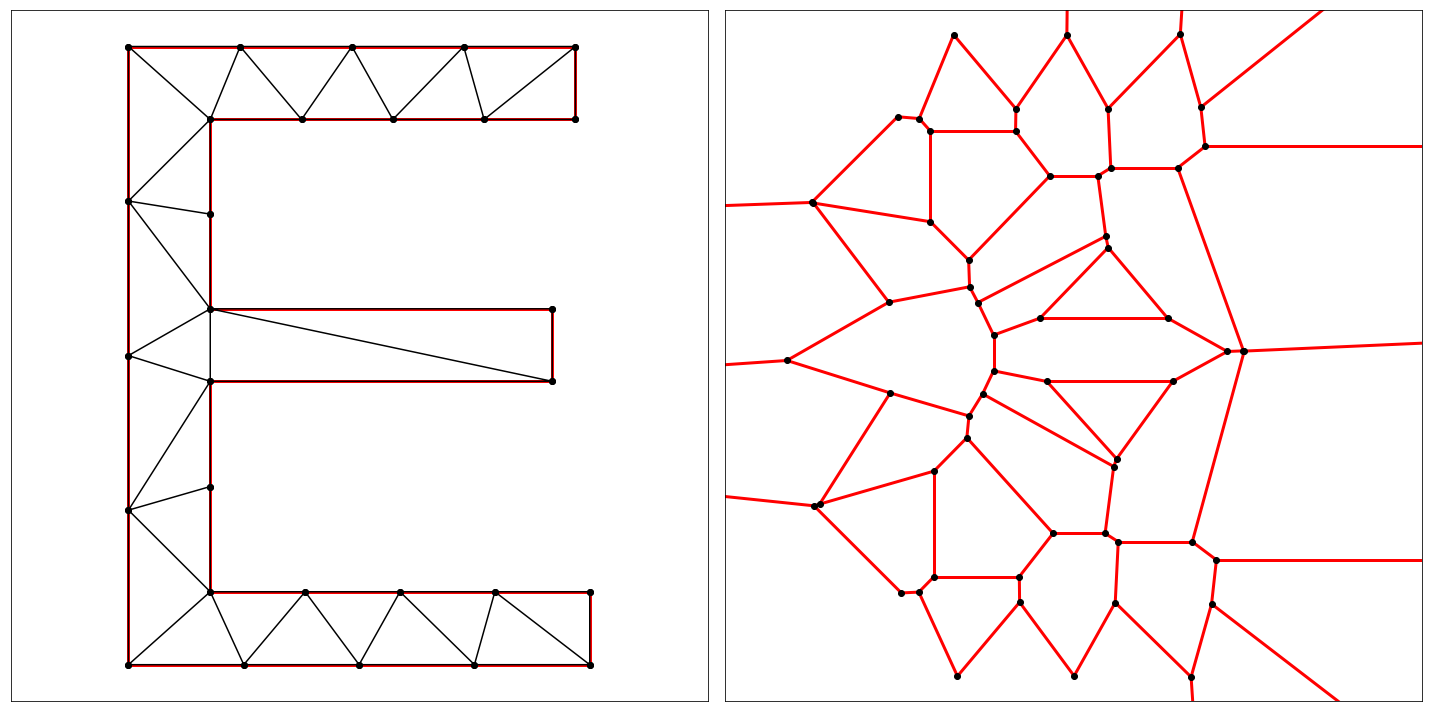

In [0]:
#title Try triangulating or calulcating voronio on just the vertices
glyph = nptris[0,glyphs.index('E')]
#print(glyph)
counts = np.bincount(glyph['triangles'].flatten())
print(counts)
#print(np.bincount(nptris[f,g]['triangles'].flatten()).sum())
T = {
  'vertices': glyph['vertices'],
#  'segments': np.array(segments),
}
#if holes:
#  T['holes'] = np.array(holes).reshape((-1,2))

opts = ''
#opts='p'  # PSLG (see https://rufat.be/triangle/delaunay.html)
#opts = 'q30' # conforming constrained Delaunay triangulation of a PSLG 
#opts = 'D' # conforming Delaunay triangulation 
tris = tr.triangulate(T, opts)
del tris['vertex_markers']
tris['labels']=1
print([(k, v.size) for k,v in tris.items() if isinstance(v, np.ndarray)])
#tr.compare(plt, glyph, tris, figsize=(20,10))
#plt.show()

points, edges, ray_origin, ray_direct = tr.voronoi(glyph['vertices'])
#points2, edges2, ray_origin2, ray_direct2 = tr.voronoi(points)
tr.compare(plt, glyph, {'vertices': points2, 'segments':edges2}, figsize=(20,10))
plt.show()

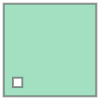

False
True


In [0]:
#title Try debugging shapely contains()
g1=shapely.geometry.LinearRing([(0, 0), (10, 0), (10, 10), (0,10)])
g2=shapely.geometry.LinearRing([(1,1),(2,1),(2,2),(1,2)])
display(shapely.geometry.Polygon(g1, [g2]))
print(g2.within(g1))  # ==False: see https://github.com/Toblerity/Shapely/issues/275
print(shapely.geometry.Polygon(g2).within(shapely.geometry.Polygon(g1))) # ==True

[(array([ 0.2 , -0.79]), array([ 0.2 , -0.78])), (array([ 0.2 , -0.78]), array([ 0.22, -0.77])), (array([ 0.22, -0.77]), array([ 0.25, -0.76])), (array([ 0.25, -0.76]), array([ 0.28, -0.7 ])), (array([ 0.28, -0.7 ]), array([ 0.49, -0.21])), (array([ 0.49, -0.21]), array([ 0.5 , -0.21])), (array([ 0.5 , -0.21]), array([ 0.74, -0.74])), (array([ 0.74, -0.74]), array([ 0.76, -0.76])), (array([ 0.76, -0.76]), array([ 0.77, -0.77])), (array([ 0.77, -0.77]), array([ 0.8 , -0.78])), (array([ 0.8 , -0.78]), array([ 0.8 , -0.79])), (array([ 0.8 , -0.79]), array([ 0.58, -0.79])), (array([ 0.58, -0.79]), array([ 0.58, -0.78])), (array([ 0.58, -0.78]), array([ 0.62, -0.77])), (array([ 0.62, -0.77]), array([ 0.63, -0.76])), (array([ 0.63, -0.76]), array([ 0.64, -0.74])), (array([ 0.64, -0.74]), array([ 0.62, -0.68])), (array([ 0.62, -0.68]), array([ 0.59, -0.6 ])), (array([ 0.59, -0.6 ]), array([ 0.36, -0.6 ])), (array([ 0.36, -0.6 ]), array([ 0.32, -0.71])), (array([ 0.32, -0.71]), array([ 0.31, -

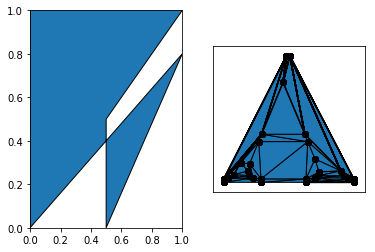

In [0]:
#title Try using shapely triangulate (but it doesn't support holes)
#points = shapely.geometry.MultiPoint([(0, 0), (1, 1), (0, 2), (2, 2), (3, 1), (1, 0)])
A = tr.get_data('A')
print([(A["vertices"][s], A["vertices"][e]) for s,e in A["segments"]])
points = shapely.geometry.MultiPoint([A["vertices"][s] for s,e in A["segments"]])
triangles = shapely.ops.triangulate(points)
print([triangle.wkt for triangle in triangles])

ax1 = plt.subplot(122)
tr.plot(ax1,
        vertices=[p for poly in triangles for p in poly.exterior.coords],
        triangles=[(i, i+1, i+2) for i in range(len(triangles))]
       )
for poly in triangles:
  ax1.add_patch(descartes.PolygonPatch(poly))
# plt.show()

#fig = plt.figure(1, figsize=(5,5), dpi=90)
ring_mixed = shapely.geometry.Polygon([(0, 0), (0, 1.8), (1, 1), (.5, .5), (.5, 0), (1, 0.8), (0, 0)])
#ax = fig.add_subplot(111)
ax = plt.subplot(121)
ax.add_patch(descartes.PolygonPatch(ring_mixed))

plt.show()

In [0]:
# Sample from https://rufat.be/triangle/API.html

#A = dict(vertices=np.array(((0, 0), (1, 0), (1, 1), (0, 1))))
A = tr.get_data('A')
del A['vertex_attributes']
print(A.keys())
B = tr.triangulate(A, opts='p')
tr.compare(plt, A, B)
# #plt.figure()
# ax1 = plt.subplot(121)
# tr.plot(ax1, **A)
# lim = ax1.axis()
# ax2 = plt.subplot(122, sharey=ax1)
# tr.plot(ax2, **B)
# ax2.axis(lim)
# plt.tight_layout()
plt.show()